In [ ]:
%pip install keras-tuner
%pip install keras_self_attention
%pip install pycm

     |████████████████████████████████| 97 kB 3.8 MB/s 
  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=e773c24e8aa0154e4a1b334427b0127f19b8bcd95b2f2cb4fbd0625c629d8f96
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention
     |████████████████████████████████| 64 kB 2.1 MB/s 
     |████████████████████████████████| 574 kB 10.3 MB/s 


In [ ]:
import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import kerastuner as kt
from kerastuner import HyperModel
from numpy import genfromtxt

import seaborn as sns
from pycm import ConfusionMatrix

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")

def reverse_one_hot(Y_input):
    return np.apply_along_axis(np.argmax, 1, Y_input) + 1

def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def misclass_perc_to_weight(input_confusion, add_base=True, func=None):
    perc_misclassified = 1.0 - np.array([ input_confusion[x,x] for x in np.arange(input_confusion.shape[0]).tolist() ])/input_confusion.sum(axis=1)
    
    base_val = min(perc_misclassified[perc_misclassified>0.0])
    if add_base:        
        perc_misclassified = perc_misclassified + base_val
    
    perc_misclassified = [ x/base_val for x in perc_misclassified]
    return dict([ (idx, func(perc_val)) if func is not None else (idx, perc_val) for idx, perc_val in enumerate(perc_misclassified) ])



def prf(model,xtest, ytest):
  y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
  y_true = np.apply_along_axis(np.argmax, 1, ytest)
  return precision_recall_fscore_support(y_true, y_pred, average="weighted")

def get_sp_pr_rc_f1(model,xtest, ytest):  
    y_pred = np.apply_along_axis(np.argmax, 1, model.predict(xtest))
    y_true = np.apply_along_axis(np.argmax, 1, ytest)
    cmres = ConfusionMatrix(actual_vector=y_true,predict_vector=y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    return cmres.TNR_Macro, pr, rc, f1
 
def get_sp_pr_rc_f1_acc(model,xtest, ytest):  
    spec, pr, rc, f1 = get_sp_pr_rc_f1(model,xtest, ytest)
    acc = model.evaluate(xtest,ytest)[-1]        
    return spec, pr, rc, f1, acc
 
def get_sp_pr_rc_f1_acc_supplied(y_pred, y_true):  
    cmres = ConfusionMatrix(actual_vector=y_true,predict_vector=y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return cmres.TNR_Macro, pr, rc, f1, acc

def ensemble_predictions(ms, xtest):
  y_pred_ms = np.array([ mx.predict(xtest) for mx in ms ])
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 2, y_pred_ms) 
  y_preds_ens_prb = np.apply_along_axis(np.max, 2, y_pred_ms) 
  idxs_with_differences = np.argwhere(np.apply_along_axis(lambda x: np.max(x) != np.min(x),0,y_preds_ens_idx)).flatten()
  y_preds_ens_final = y_preds_ens_idx[0]
  y_preds_ens_final[idxs_with_differences] = y_preds_ens_idx[np.apply_along_axis(np.argmax,0,y_preds_ens_prb[:,idxs_with_differences]),idxs_with_differences]
  return y_preds_ens_final




In [ ]:

def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

# data extraction
def getData(is500=True, shuffle=False, ise2e=False, include_secondary=False, validation_split=None, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Train_Data" if ise2e else "Fold_10_Train_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Test_Data" if ise2e else "Fold_10_Test_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    X_validation = Y_validation = None
    if validation_split is not None:
        # sklearn split shuffles anyway
        X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_split)

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eData(is500=True, shuffle=False, include_secondary=False, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Data_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Secondary_Data_1136.h5', 'r') if include_secondary else h5.File(
        f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


In [ ]:
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   

def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def get_combined_features_from_models(
        to_combine,
        X_train_combined, Y_train_combined,
        X_validation_combined, Y_validation_combined,
        X_test_combined, Y_test_combined,
        reverse_one_hot=False,
        normalize_X_func=None):
    models = []
    models_dict = {}
    X_trains_out = []
    X_test_out = []
    X_validation_out = []
    XY_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

    if reverse_one_hot:
        Y_train_new = np.apply_along_axis(np.argmax, 1, Y_train_combined) + 1
        Y_test_new = np.apply_along_axis(np.argmax, 1, Y_test_combined) + 1
        Y_validation_new = np.apply_along_axis(np.argmax, 1, Y_validation_combined) + 1
    else:
        Y_train_new = Y_train_combined.copy()
        Y_test_new = Y_test_combined.copy()
        Y_validation_new = np.apply_along_axis(np.argmax, 1, Y_validation_combined) + 1

    for model_file_name, layer_name, kwargs in to_combine:
        model_here = None
        if isinstance(model_file_name, tf.keras.models.Model):
            model_here = model_file_name
            model_file_name = model_here.name
        else:
            if model_file_name in models_dict.keys():
                model_here = models_dict[model_file_name]
            else:
                model_here = tf.keras.models.load_model(model_file_name,
                                                        **kwargs) if kwargs is not None else tf.keras.models.load_model \
                    (model_file_name)

        features_model = Model(model_here.input,
                               get_layer_by_name(model_here.layers, layer_name).output)
        if normalize_X_func is None:
            X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
            X_test_out.append(np.array(features_model.predict(X_test_combined), dtype='float64'))
            X_validation_out.append(np.array(features_model.predict(X_validation_combined), dtype='float64'))
        else:
            X_trains_out.append(np.array(normalize_X_func(features_model.predict(X_train_combined)), dtype='float64'))
            X_test_out.append(np.array(normalize_X_func(features_model.predict(X_test_combined)), dtype='float64'))
            X_validation_out.append(np.array(normalize_X_func(features_model.predict(X_validation_combined)), dtype='float64'))
            
        XY_dict[model_file_name][layer_name]['Train']['X'] = X_trains_out[-1]
        XY_dict[model_file_name][layer_name]['Train']['Y'] = Y_train_new
        
        XY_dict[model_file_name][layer_name]['Test']['X'] = X_test_out[-1]
        XY_dict[model_file_name][layer_name]['Test']['Y'] = Y_test_new
        
        XY_dict[model_file_name][layer_name]['Validation']['X'] = X_validation_out[-1]
        XY_dict[model_file_name][layer_name]['Validation']['Y'] = Y_validation_new
        
        
        models.append(((model_file_name, layer_name), (model_here, features_model)))
        models_dict[model_file_name] = model_here

    X_train_new = np.concatenate(tuple(X_trains_out), axis=1)
    X_test_new = np.concatenate(tuple(X_test_out), axis=1)
    X_validation_new = np.concatenate(tuple(X_validation_out), axis=1)


    data_train = (X_train_new, Y_train_new)
    data_test = (X_test_new, Y_test_new)
    data_validation = (X_validation_new, Y_validation_new)

    return models, data_train, data_validation, data_test, XY_dict



def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m


def compile_and_fit_model_with_tb(model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_every_epoch=True,
                                  save_final=False,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    tb_callback = TensorBoard(log_dir=f'{m.name}_logs', histogram_freq=kwargs.pop("histogram_freq", 1))
    if save_every_epoch:
        tb_callback.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.2f}'))
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=[tb_callback], verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)
    # m.save(f"{m.name}_Tenth_Fold_New_Model_500_8") #Save the model


def compile_model_and_fit_with_custom_loop(model_func,
                                           model_name,
                                           input_shape,
                                           X_train,
                                           Y_train,
                                           **kwargs):
    make_dir_if_not_exist(model_name)
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    train_writer = create_file_writer(f'{m.name}_logs/train/')
    test_writer = create_file_writer(f'{m.name}_logs/test/')
    train_step = test_step = 0

    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam()
    num_epochs = kwargs.get("epochs", 10)

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    BATCH_SIZE = kwargs.get("batch_size", 32)
    X_test, Y_test = kwargs.get("validation_data", (None, None))
    if X_test is None:
        raise ValueError("Missing X validation data")
    if Y_test is None:
        raise ValueError("Missing Y validation data")

    train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    train_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    train_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    test_dataset_tf = train_dataset_tf.batch(BATCH_SIZE)
    test_dataset_tf = train_dataset_tf.prefetch(AUTOTUNE)

    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    for epoch in range(num_epochs):
        # Iterate through training set
        for batch_idx, (x, y) in enumerate(train_dataset_tf):
            with tf.GradientTape() as tape:
                y_pred = m(x, training=True)
                loss = loss_fn(y, y_pred)

            gradients = tape.gradient(loss, m.trainable_weights)
            optimizer.apply_gradients(zip(gradients, m.trainable_weights))
            acc_metric.update_state(y, y_pred)

            with train_writer.as_default():
                tf.summary.scalar("Loss", loss, step=train_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=train_step,
                )
                train_step += 1
        # Reset accuracy in between epochs (and for testing and test)
        acc_metric.reset_states()
        # Iterate through test set
        for batch_idx, (x, y) in enumerate(test_dataset_tf):
            y_pred = m(x, training=False)
            loss = loss_fn(y, y_pred)
            acc_metric.update_state(y, y_pred)
            with test_writer.as_default():
                tf.summary.scalar("Loss", loss, step=test_step)
                tf.summary.scalar(
                    "Accuracy", acc_metric.result(), step=test_step,
                )
                test_step += 1

        acc_metric.reset_states()  # Reset accuracy in between epochs (and for testing and test)

    return m


def reinitialize_weights(model):
    for ix, layer in enumerate(model.layers):
        if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])
    return model


def reverse_tensor(X):
    return tf.gather(X, tf.reverse(tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32), (0,)))


def run_mirrored_strategy(model_func, base_batch_size, nepochs, x_train, y_train, x_test, y_test, **kwargs):
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = model_func()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=tf.keras.metrics.SparseCategoricalAccuracy()
        )
    batch_size_mirr_strat = base_batch_size * strategy.num_replicas_in_sync
    history = model.fit(x_train, y_train, epochs=nepochs, batch_size=batch_size_mirr_strat,
                        validation_data=(x_test, y_test),
                        **kwargs)
    return model, history


def sparse_setdiff(a1, a2):
    a1a = a1.reshape(a1.shape[0], -1)
    a2a = a2.reshape(a2.shape[0], -1)
    spa2a = [np.where(x)[0].tolist() for x in a2a]
    spa1a = [np.where(x)[0].tolist() for x in a1a]
    idxs_to_keep = []
    for idx, sample in enumerate(spa1a):
        try:
            spa2a.index(sample)
        except ValueError:
            # not in list
            idxs_to_keep.append(idx)
    return a1[idxs_to_keep], idxs_to_keep


def unpacking_apply_along_axis(all_args):
    """
    Like numpy.apply_along_axis(), but with arguments in a tuple
    instead.

    This function is useful with multiprocessing.Pool().map(): (1)
    map() only handles functions that take a single argument, and (2)
    this function can generally be imported from a module, as required
    by map().
    """
    (func1d, axis, arr, args, kwargs) = all_args
    # return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)


def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr, args, kwargs)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)


In [ ]:
def get_input_features(X_data, m1, m2, m1_layer_name = "leaky_re_lu_6", m2_layer_name = "dropout_7"):
  extractor_m1 = Model(inputs=m1.inputs, outputs=m1.get_layer(m1_layer_name).output)
  features_m1 = extractor_m1.predict(X_data)
  extractor_m2 = Model(inputs=m2.inputs, outputs=m2.get_layer(m2_layer_name).output)
  features_m2 = extractor_m2.predict(X_data)
  return tf.concat([features_m1,features_m2],1)

In [ ]:
# 'new' data 
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData(is500=False,
                                                                                                    include_secondary=False,
                                                                                                    isColab=True)
X_train_1000e_w2nd, Y_train_1000e_w2nd, X_test_1000e_w2nd, Y_test_1000e_w2nd, X_val_1000e_w2nd, Y_val_1000e_w2nd = getE2eData(is500=False, include_secondary=True, isColab=True)
X_train_1000e_j2nd, Y_train_1000e_j2nd, X_test_1000e_j2nd, Y_test_1000e_j2nd, X_val_1000e_j2nd, Y_val_1000e_j2nd = getE2eDataJustSecondary(isColab=True)

In [ ]:
# merge into a new train:
X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )    

X_new_train_j2nd = np.concatenate( (X_train_1000e_j2nd, X_val_1000e_j2nd), axis=0 )
Y_new_train_j2nd = np.concatenate( (Y_train_1000e_j2nd, Y_val_1000e_j2nd), axis=0 )    

X_new_train_w2nd = np.concatenate( (X_train_1000e_w2nd, X_val_1000e_w2nd), axis=0 )
Y_new_train_w2nd = np.concatenate( (Y_train_1000e_w2nd, Y_val_1000e_w2nd), axis=0 )  

In [ ]:
# load model A history from previous run
history_rnn_A_df = pd.read_csv(f"/content/drive/MyDrive/ncRNA/data/history/history_log_cnn_A_256_20210827212633_20210827.csv")
plot_history_df(history_rnn_A_df)
# load model A from previous run
cnn_A = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/cnn_A_256_20210827212633_model_491_0.995")
# evalutate model A on the data sets

# cnn_A.evaluate(X_test_1000e, Y_test_1000e)
# cnn_A.evaluate(X_val_1000e, Y_val_1000e)
# cnn_A.evaluate(X_train_1000e, Y_train_1000e)

cnn_A_train_nums = get_sp_pr_rc_f1_acc(cnn_A,X_train_1000e, Y_train_1000e)
cnn_A_val_nums = get_sp_pr_rc_f1_acc(cnn_A,X_val_1000e, Y_val_1000e)
cnn_A_test_nums = get_sp_pr_rc_f1_acc(cnn_A,X_test_1000e, Y_test_1000e)

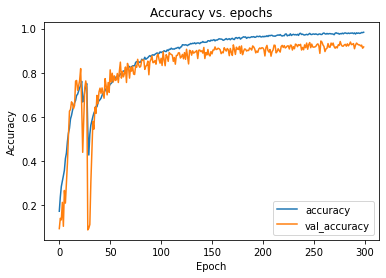

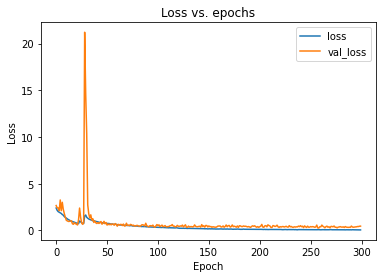

27/27 [==============================] - 49s 2s/step - loss: 0.2872 - accuracy: 0.9359


In [ ]:
# load model E history from previous run
history_rnn_E_df = pd.read_csv(f"/content/drive/MyDrive/ncRNA/data/history/history_log_rnn_E_patchwork.csv")
plot_history_df(history_rnn_E_df)
# load model E from previous run
rnn_E = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/rnn_E_20210827221034_model_060_0.983")
# evalutate model E on the data sets
# rnn_E.evaluate(X_test_1000e, Y_test_1000e)
# rnn_E.evaluate(X_val_1000e, Y_val_1000e)
# rnn_E.evaluate(X_train_1000e, Y_train_1000e)

rnn_E_train_nums = get_sp_pr_rc_f1_acc(rnn_E,X_train_1000e, Y_train_1000e)
rnn_E_val_nums = get_sp_pr_rc_f1_acc(rnn_E,X_val_1000e, Y_val_1000e)
rnn_E_test_nums = get_sp_pr_rc_f1_acc(rnn_E,X_test_1000e, Y_test_1000e)

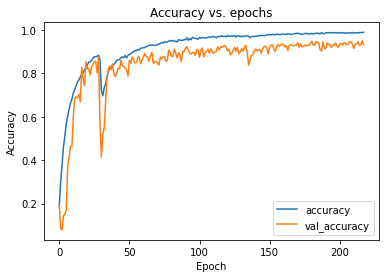

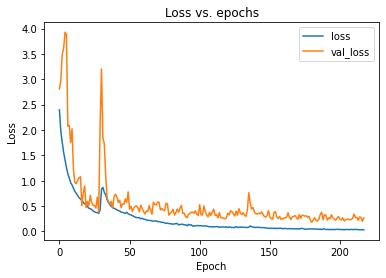

27/27 [==============================] - 48s 2s/step - loss: 0.2415 - accuracy: 0.9476


In [ ]:
# load Merged Parallel A&E history from previous run
history_mergedParallel_AE_df = pd.read_csv(f"/content/drive/MyDrive/ncRNA/data/history/history_log_mcrnn_AE_patchwork.csv")
plot_history_df(history_mergedParallel_AE_df)
# load model E from previous run
mergedParallel_AE = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/mcrnn_AE_20210830185445_model_092_0.990")
# evalutate model E on the data sets
# mergedParallel_AE.evaluate(X_test_1000e, Y_test_1000e)
# mergedParallel_AE.evaluate(X_val_1000e, Y_val_1000e)
# mergedParallel_AE.evaluate(X_train_1000e, Y_train_1000e)

mergedParallel_AE_train_nums = get_sp_pr_rc_f1_acc(mergedParallel_AE,X_train_1000e, Y_train_1000e)
mergedParallel_AE_val_nums = get_sp_pr_rc_f1_acc(mergedParallel_AE,X_val_1000e, Y_val_1000e)
mergedParallel_AE_test_nums = get_sp_pr_rc_f1_acc(mergedParallel_AE,X_test_1000e, Y_test_1000e)

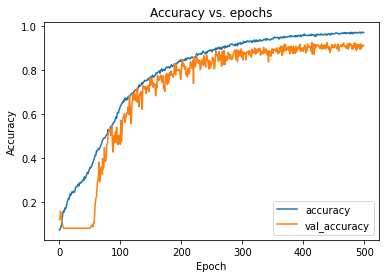

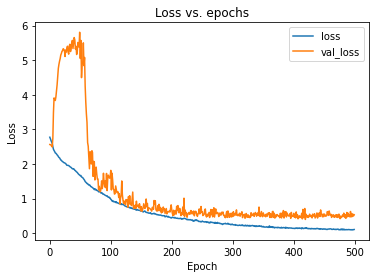

27/27 [==============================] - 2s 58ms/step - loss: 0.4045 - accuracy: 0.9149


In [ ]:
# load Sequential A&E history from previous run
history_seq_AE_df = pd.read_csv(f"/content/drive/MyDrive/ncRNA/data/history/history_log_seQcrnn_AE_20210826224137_20210826.csv")
plot_history_df(history_seq_AE_df)
# load model E from previous run
seq_AE = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/seQcrnn_AE_20210830170918_saved_model_after_fit")
# evalutate model E on the data sets
# seq_AE.evaluate(X_test_1000e, Y_test_1000e)
# seq_AE.evaluate(X_val_1000e, Y_val_1000e)
# seq_AE.evaluate(X_train_1000e, Y_train_1000e)

seq_AE_train_nums = get_sp_pr_rc_f1_acc(seq_AE,X_train_1000e, Y_train_1000e)
seq_AE_val_nums = get_sp_pr_rc_f1_acc(seq_AE,X_val_1000e, Y_val_1000e)
seq_AE_test_nums = get_sp_pr_rc_f1_acc(seq_AE,X_test_1000e, Y_test_1000e)

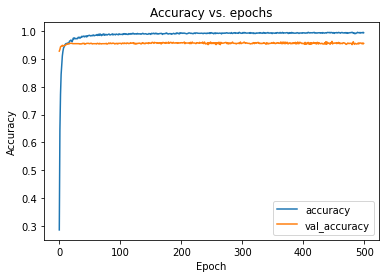

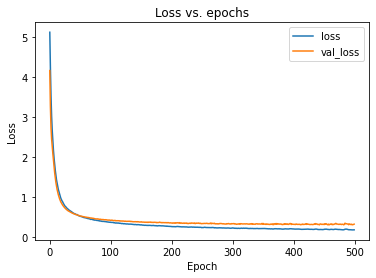

27/27 [==============================] - 0s 1ms/step - loss: 0.3155 - accuracy: 0.9662


In [ ]:
# Load Collaborative A&E history from previous run
history_collabcnn_AE_df = pd.read_csv(f"/content/drive/MyDrive/ncRNA/data/history/history_log_combined_model_cnn_A_256_20210827212633_rnn_E_20210827221034_20210830180436_20210830.csv")
plot_history_df(history_collabcnn_AE_df)

# # Load Collaborative A&E run from before...
collaborative_AE = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/combined_model_cnn_A_256_20210827212633_rnn_E_20210827221034_20210830180436_model_481_0.997")

# collaborative_AE.evaluate(get_input_features(X_test_1000e, cnn_A,rnn_E), Y_test_1000e)
# collaborative_AE.evaluate(get_input_features(X_val_1000e, cnn_A,rnn_E), Y_val_1000e)
# collaborative_AE.evaluate(get_input_features(X_train_1000e, cnn_A,rnn_E), Y_train_1000e)

collaborative_AE_train_nums = get_sp_pr_rc_f1_acc(collaborative_AE,get_input_features(X_train_1000e, cnn_A,rnn_E), Y_train_1000e)
collaborative_AE_val_nums = get_sp_pr_rc_f1_acc(collaborative_AE,get_input_features(X_val_1000e, cnn_A,rnn_E), Y_val_1000e)
collaborative_AE_test_nums = get_sp_pr_rc_f1_acc(collaborative_AE,get_input_features(X_test_1000e, cnn_A,rnn_E), Y_test_1000e)

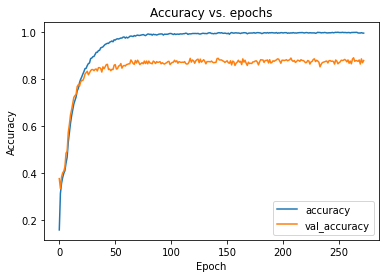

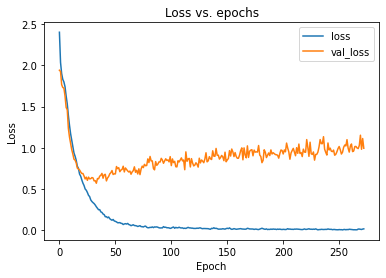

27/27 [==============================] - 23s 864ms/step - loss: 0.8743 - accuracy: 0.8869


In [ ]:
# Load the ncRFP model with history

history_ncRFP_df = pd.read_csv(f"/content/drive/MyDrive/ncRNA/data/history/history_log_ncRFP_20210905210413_20210905.csv")
plot_history_df(history_ncRFP_df)

ncRFP_model = load_model("/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/ncRFP_20210905210413_model_250_0.999")

ncRFP_train_nums = get_sp_pr_rc_f1_acc(ncRFP_model,X_train_1000e, Y_train_1000e)
ncRFP_val_nums = get_sp_pr_rc_f1_acc(ncRFP_model,X_val_1000e, Y_val_1000e)
ncRFP_test_nums = get_sp_pr_rc_f1_acc(ncRFP_model,X_test_1000e, Y_test_1000e)


In [ ]:
# create Ensemble A&E results

# load model A and model E from disk
model_cnn_A = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/cnn_A_256_20210827212633_model_491_0.995")
model_rnn_E = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/rnn_E_20210827221034_model_060_0.983")

ms = [model_cnn_A, model_rnn_E]

ens_AE_test_nums = get_sp_pr_rc_f1_acc_supplied(ensemble_predictions(ms, X_test_1000e)+1,reverse_one_hot(Y_test_1000e))
ens_AE_val_nums = get_sp_pr_rc_f1_acc_supplied(ensemble_predictions(ms, X_val_1000e)+1,reverse_one_hot(Y_val_1000e))
ens_AE_train_nums = get_sp_pr_rc_f1_acc_supplied(ensemble_predictions(ms, X_train_1000e)+1,reverse_one_hot(Y_train_1000e))

In [ ]:
def averaged_ensemble_predictions(ms, xtest):
  y_pred_ms = np.array([ mx.predict(xtest) for mx in ms ])
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx


In [ ]:
# create Traditional Ensemble A&E results

# load model A and model E from disk
model_cnn_A = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/cnn_A_256_20210827212633_model_491_0.995")
model_rnn_E = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/rnn_E_20210827221034_model_060_0.983")

ms = [model_cnn_A, model_rnn_E]

aens_AE_test_nums = get_sp_pr_rc_f1_acc_supplied(averaged_ensemble_predictions(ms, X_test_1000e)+1,reverse_one_hot(Y_test_1000e))
aens_AE_val_nums = get_sp_pr_rc_f1_acc_supplied(averaged_ensemble_predictions(ms, X_val_1000e)+1,reverse_one_hot(Y_val_1000e))
aens_AE_train_nums = get_sp_pr_rc_f1_acc_supplied(averaged_ensemble_predictions(ms, X_train_1000e)+1,reverse_one_hot(Y_train_1000e))



In [ ]:
print(aens_AE_train_nums)
print(aens_AE_val_nums)
print(aens_AE_test_nums)

(1.0, 1.0, 1.0, 1.0, 1.0)
(0.996292220041046, 0.9598037317721633, 0.9556592765460911, 0.9564682687712835, 0.9556592765460911)
(0.9976690895333451, 0.9727163239578074, 0.972027972027972, 0.9721044525214404, 0.972027972027972)


In [ ]:
print(ncRFP_train_nums)
print(ncRFP_val_nums)
print(ncRFP_test_nums)

(1.0, 1.0, 1.0, 1.0, 1.0)
(0.9887172521542199, 0.8654830820535091, 0.8646441073512252, 0.8642140619681684, 0.8646441102027893)
(0.9905712214124355, 0.8878628620243019, 0.8869463869463869, 0.8867088456230519, 0.8869463801383972)


In [ ]:
print(cnn_A_train_nums)
print(rnn_E_train_nums)
print(mergedParallel_AE_train_nums)
print(seq_AE_train_nums)
print(ens_AE_train_nums)

print(collaborative_AE_train_nums)

(1.0, 1.0, 1.0, 1.0, 1.0)
(0.9997318151287329, 0.9968496163511864, 0.9967920676582094, 0.9967967472038156, 0.9967920780181885)
(0.9999877938627542, 0.9998544466801016, 0.9998541848935549, 0.9998541840590908, 0.9998542070388794)
(0.9999023605829893, 0.998841294881016, 0.9988334791484398, 0.9988315694319873, 0.9988334774971008)
(1.0, 1.0, 1.0, 1.0, 1.0)


In [ ]:
print(cnn_A_val_nums)
print(rnn_E_val_nums)
print(mergedParallel_AE_val_nums)
print(seq_AE_val_nums)
print(ens_AE_val_nums)
print(collaborative_AE_val_nums)

(0.9950336202063702, 0.9434307417627293, 0.94049008168028, 0.9411780580676999, 0.9404900670051575)
(0.9937561768462917, 0.9358901389695907, 0.9253208868144691, 0.9275403125236205, 0.9253208637237549)
(0.9944387176609205, 0.9421327734753945, 0.9334889148191365, 0.9347264060039374, 0.9334889054298401)
(0.9922975624428718, 0.9202939644304872, 0.9078179696616102, 0.9106816301005174, 0.9078179597854614)
(0.9961954670587289, 0.9582049395202565, 0.9544924154025671, 0.9552194745555799, 0.9544923901557922)


In [ ]:
print(cnn_A_test_nums)
print(rnn_E_test_nums)
print(mergedParallel_AE_test_nums)
print(seq_AE_test_nums)
print(ens_AE_test_nums)
print(collaborative_AE_test_nums)

(0.9964092843467676, 0.9595733715094285, 0.9568764568764568, 0.9574605155391565, 0.9568764567375183)
(0.9946430516015923, 0.9395244619429167, 0.9358974358974359, 0.9366785904779775, 0.9358974099159241)
(0.995610740102799, 0.9518402020999224, 0.9475524475524476, 0.9475848456101366, 0.9475524425506592)
(0.9928909475202564, 0.9234689691006129, 0.914918414918415, 0.916266010389619, 0.9149184226989746)
(0.9971842406910046, 0.9689030220543328, 0.9662004662004662, 0.9667478902715902, 0.9662004709243774)


In [ ]:
import regex as re

cnn_A_dirs = [d for d in os.listdir('./drive/MyDrive/data_papers/ncRNA/model_checkpoints/') if re.match(r'cnn_A_.*saved_model_after_fit', d)]
seq_AE_dirs = [d for d in os.listdir('./drive/MyDrive/data_papers/ncRNA/model_checkpoints/') if re.match(r'seQcrnn_AE.*saved_model_after_fit', d)]
collaborative_AE_files = [f for f in os.listdir('./drive/MyDrive/data_papers/ncRNA/model_checkpoints/') if re.match(r'collabcrnn_AE_.*.h5', f)]


In [ ]:
cnn_A_stat_results = list()
for d in cnn_A_dirs:
  # load model A from previous run
  cnn_A = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/{d}")
  cnn_A_train_nums = get_sp_pr_rc_f1_acc(cnn_A,X_train_1000e, Y_train_1000e)
  cnn_A_val_nums = get_sp_pr_rc_f1_acc(cnn_A,X_val_1000e, Y_val_1000e)
  cnn_A_test_nums = get_sp_pr_rc_f1_acc(cnn_A,X_test_1000e, Y_test_1000e)
  cnn_A_stat_results.append( dict( { 'train' : cnn_A_train_nums, 'val' : cnn_A_val_nums, 'test' : cnn_A_test_nums }) )


In [ ]:
seq_AE_stat_results = list()
for d in seq_AE_dirs:
  # load model A from previous run
  seq_AE = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/{d}")
  seq_AE_train_nums = get_sp_pr_rc_f1_acc(seq_AE,X_train_1000e, Y_train_1000e)
  seq_AE_val_nums = get_sp_pr_rc_f1_acc(seq_AE,X_val_1000e, Y_val_1000e)
  seq_AE_test_nums = get_sp_pr_rc_f1_acc(seq_AE,X_test_1000e, Y_test_1000e)
  seq_AE_stat_results.append( dict( { 'train' : seq_AE_train_nums, 'val' : seq_AE_val_nums, 'test' : seq_AE_test_nums }) )

27/27 [==============================] - 2s 59ms/step - loss: 0.4045 - accuracy: 0.9149


In [ ]:
def get_sp_pr_rc_f1_acc_collaborative(model, m1, m2, xtest, ytest, m1_layer_name = "leaky_re_lu_6", m2_layer_name = "dropout_7"):
  xfeatures = get_input_features(xtest,m1,m2,m1_layer_name,m2_layer_name)
  y_pred = model.predict(xfeatures)
  y_predicted_number = np.apply_along_axis(np.argmax, 1, y_pred) + 1
  ytest_number = reverse_one_hot(ytest)
  cmres = ConfusionMatrix(actual_vector=ytest_number,predict_vector=y_predicted_number)
  pr, rc, f1, _ = precision_recall_fscore_support(ytest_number, y_predicted_number, average="weighted")   
  acc = accuracy_score(ytest_number, y_predicted_number)
  return cmres.TNR_Macro, pr, rc, f1, acc


In [ ]:
collaborative_AE_stat_results = list()
for f in collaborative_AE_files:
  print(f)
  # load model A from previous run
  collaborative_AE = load_model(f"/content/drive/MyDrive/data_papers/ncRNA/model_checkpoints/{f}")
  collaborative_AE_train_nums = get_sp_pr_rc_f1_acc_collaborative(collaborative_AE, model_cnn_A, model_rnn_E, X_train_1000e, Y_train_1000e)
  collaborative_AE_val_nums = get_sp_pr_rc_f1_acc_collaborative(collaborative_AE, model_cnn_A, model_rnn_E,X_val_1000e, Y_val_1000e)
  collaborative_AE_test_nums = get_sp_pr_rc_f1_acc_collaborative(collaborative_AE, model_cnn_A, model_rnn_E,X_test_1000e, Y_test_1000e)
  collaborative_AE_stat_results.append( dict( { 'train' : collaborative_AE_train_nums, 'val' : collaborative_AE_val_nums, 'test' : collaborative_AE_test_nums }) )

collabcrnn_AE_repeat1_20210904123524.h5
collabcrnn_AE_repeat2_20210904123957.h5
collabcrnn_AE_repeat3_20210904124443.h5
collabcrnn_AE_repeat4_20210904124923.h5
collabcrnn_AE_repeat5_20210904125402.h5
collabcrnn_AE_repeat6_20210904125840.h5
collabcrnn_AE_repeat7_20210904130322.h5
collabcrnn_AE_repeat8_20210904130803.h5
collabcrnn_AE_repeat9_20210904131248.h5
collabcrnn_AE_repeat10_20210904131737.h5
collabcrnn_AE_repeat11_20210904132222.h5
collabcrnn_AE_repeat12_20210904132701.h5
collabcrnn_AE_repeat13_20210904133141.h5
collabcrnn_AE_repeat14_20210904133619.h5
collabcrnn_AE_repeat15_20210904134101.h5
collabcrnn_AE_repeat16_20210904134535.h5
collabcrnn_AE_repeat17_20210904135016.h5
collabcrnn_AE_repeat18_20210904135457.h5
collabcrnn_AE_repeat19_20210904135936.h5
collabcrnn_AE_repeat20_20210904140428.h5


In [ ]:
all_stat_results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda : [])))


In [ ]:

all_stat_results['cnn_A']['train']['sp'] = [ stat_dict['train'][0] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['train']['pr'] = [ stat_dict['train'][1] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['train']['rc'] = [ stat_dict['train'][2] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['train']['f1'] = [ stat_dict['train'][3] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['train']['acc'] = [ stat_dict['train'][4] for stat_dict in cnn_A_stat_results ] 

all_stat_results['cnn_A']['val']['sp'] = [ stat_dict['val'][0] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['val']['pr'] = [ stat_dict['val'][1] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['val']['rc'] = [ stat_dict['val'][2] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['val']['f1'] = [ stat_dict['val'][3] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['val']['acc'] = [ stat_dict['val'][4] for stat_dict in cnn_A_stat_results ] 

all_stat_results['cnn_A']['test']['sp'] = [ stat_dict['test'][0] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['test']['pr'] = [ stat_dict['test'][1] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['test']['rc'] = [ stat_dict['test'][2] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['test']['f1'] = [ stat_dict['test'][3] for stat_dict in cnn_A_stat_results ] 
all_stat_results['cnn_A']['test']['acc'] = [ stat_dict['test'][4] for stat_dict in cnn_A_stat_results ] 

all_stat_results['seq_AE']['train']['sp'] = [ stat_dict['train'][0] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['train']['pr'] = [ stat_dict['train'][1] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['train']['rc'] = [ stat_dict['train'][2] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['train']['f1'] = [ stat_dict['train'][3] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['train']['acc'] = [ stat_dict['train'][4] for stat_dict in seq_AE_stat_results ] 

all_stat_results['seq_AE']['val']['sp'] = [ stat_dict['val'][0] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['val']['pr'] = [ stat_dict['val'][1] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['val']['rc'] = [ stat_dict['val'][2] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['val']['f1'] = [ stat_dict['val'][3] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['val']['acc'] = [ stat_dict['val'][4] for stat_dict in seq_AE_stat_results ] 

all_stat_results['seq_AE']['test']['sp'] = [ stat_dict['test'][0] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['test']['pr'] = [ stat_dict['test'][1] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['test']['rc'] = [ stat_dict['test'][2] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['test']['f1'] = [ stat_dict['test'][3] for stat_dict in seq_AE_stat_results ] 
all_stat_results['seq_AE']['test']['acc'] = [ stat_dict['test'][4] for stat_dict in seq_AE_stat_results ] 


all_stat_results['collab_AE']['train']['sp'] = [ stat_dict['train'][0] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['train']['pr'] = [ stat_dict['train'][1] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['train']['rc'] = [ stat_dict['train'][2] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['train']['f1'] = [ stat_dict['train'][3] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['train']['acc'] = [ stat_dict['train'][4] for stat_dict in collaborative_AE_stat_results ] 

all_stat_results['collab_AE']['val']['sp'] = [ stat_dict['val'][0] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['val']['pr'] = [ stat_dict['val'][1] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['val']['rc'] = [ stat_dict['val'][2] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['val']['f1'] = [ stat_dict['val'][3] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['val']['acc'] = [ stat_dict['val'][4] for stat_dict in collaborative_AE_stat_results ] 

all_stat_results['collab_AE']['test']['sp'] = [ stat_dict['test'][0] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['test']['pr'] = [ stat_dict['test'][1] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['test']['rc'] = [ stat_dict['test'][2] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['test']['f1'] = [ stat_dict['test'][3] for stat_dict in collaborative_AE_stat_results ] 
all_stat_results['collab_AE']['test']['acc'] = [ stat_dict['test'][4] for stat_dict in collaborative_AE_stat_results ] 



In [ ]:
averages_train = [  
  [ np.mean(all_stat_results['cnn_A']['train']['sp']), np.mean(all_stat_results['cnn_A']['train']['pr']), np.mean(all_stat_results['cnn_A']['train']['rc']), np.mean(all_stat_results['cnn_A']['train']['f1']), np.mean(all_stat_results['cnn_A']['train']['acc']) ],                 
  [ np.mean(all_stat_results['seq_AE']['train']['sp']), np.mean(all_stat_results['seq_AE']['train']['pr']), np.mean(all_stat_results['seq_AE']['train']['rc']), np.mean(all_stat_results['seq_AE']['train']['f1']), np.mean(all_stat_results['seq_AE']['train']['acc']) ],                 
  [ np.mean(all_stat_results['collab_AE']['train']['sp']), np.mean(all_stat_results['collab_AE']['train']['pr']), np.mean(all_stat_results['collab_AE']['train']['rc']), np.mean(all_stat_results['collab_AE']['train']['f1']), np.mean(all_stat_results['collab_AE']['train']['acc']) ]                 
]

averages_val = [  
  [ np.mean(all_stat_results['cnn_A']['val']['sp']), np.mean(all_stat_results['cnn_A']['val']['pr']), np.mean(all_stat_results['cnn_A']['val']['rc']), np.mean(all_stat_results['cnn_A']['val']['f1']), np.mean(all_stat_results['cnn_A']['val']['acc']) ],                 
  [ np.mean(all_stat_results['seq_AE']['val']['sp']), np.mean(all_stat_results['seq_AE']['val']['pr']), np.mean(all_stat_results['seq_AE']['val']['rc']), np.mean(all_stat_results['seq_AE']['val']['f1']), np.mean(all_stat_results['seq_AE']['val']['acc']) ],                 
  [ np.mean(all_stat_results['collab_AE']['val']['sp']), np.mean(all_stat_results['collab_AE']['val']['pr']), np.mean(all_stat_results['collab_AE']['val']['rc']), np.mean(all_stat_results['collab_AE']['val']['f1']), np.mean(all_stat_results['collab_AE']['val']['acc']) ]                 
]

averages_test = [  
  [ np.mean(all_stat_results['cnn_A']['test']['sp']), np.mean(all_stat_results['cnn_A']['test']['pr']), np.mean(all_stat_results['cnn_A']['test']['rc']), np.mean(all_stat_results['cnn_A']['test']['f1']), np.mean(all_stat_results['cnn_A']['test']['acc']) ],                 
  [ np.mean(all_stat_results['seq_AE']['test']['sp']), np.mean(all_stat_results['seq_AE']['test']['pr']), np.mean(all_stat_results['seq_AE']['test']['rc']), np.mean(all_stat_results['seq_AE']['test']['f1']), np.mean(all_stat_results['seq_AE']['test']['acc']) ],                 
  [ np.mean(all_stat_results['collab_AE']['test']['sp']), np.mean(all_stat_results['collab_AE']['test']['pr']), np.mean(all_stat_results['collab_AE']['test']['rc']), np.mean(all_stat_results['collab_AE']['test']['f1']), np.mean(all_stat_results['collab_AE']['test']['acc']) ]                 
]


In [ ]:
stdev_train = [  
  [ np.std(all_stat_results['cnn_A']['train']['sp']), np.std(all_stat_results['cnn_A']['train']['pr']), np.std(all_stat_results['cnn_A']['train']['rc']), np.std(all_stat_results['cnn_A']['train']['f1']), np.std(all_stat_results['cnn_A']['train']['acc']) ],                 
  [ np.std(all_stat_results['seq_AE']['train']['sp']), np.std(all_stat_results['seq_AE']['train']['pr']), np.std(all_stat_results['seq_AE']['train']['rc']), np.std(all_stat_results['seq_AE']['train']['f1']), np.std(all_stat_results['seq_AE']['train']['acc']) ],                 
  [ np.std(all_stat_results['collab_AE']['train']['sp']), np.std(all_stat_results['collab_AE']['train']['pr']), np.std(all_stat_results['collab_AE']['train']['rc']), np.std(all_stat_results['collab_AE']['train']['f1']), np.std(all_stat_results['collab_AE']['train']['acc']) ]                 
]

stdev_val = [  
  [ np.std(all_stat_results['cnn_A']['val']['sp']), np.std(all_stat_results['cnn_A']['val']['pr']), np.std(all_stat_results['cnn_A']['val']['rc']), np.std(all_stat_results['cnn_A']['val']['f1']), np.std(all_stat_results['cnn_A']['val']['acc']) ],                 
  [ np.std(all_stat_results['seq_AE']['val']['sp']), np.std(all_stat_results['seq_AE']['val']['pr']), np.std(all_stat_results['seq_AE']['val']['rc']), np.std(all_stat_results['seq_AE']['val']['f1']), np.std(all_stat_results['seq_AE']['val']['acc']) ],                 
  [ np.std(all_stat_results['collab_AE']['val']['sp']), np.std(all_stat_results['collab_AE']['val']['pr']), np.std(all_stat_results['collab_AE']['val']['rc']), np.std(all_stat_results['collab_AE']['val']['f1']), np.std(all_stat_results['collab_AE']['val']['acc']) ]                 
]

stdev_test = [  
  [ np.std(all_stat_results['cnn_A']['test']['sp']), np.std(all_stat_results['cnn_A']['test']['pr']), np.std(all_stat_results['cnn_A']['test']['rc']), np.std(all_stat_results['cnn_A']['test']['f1']), np.std(all_stat_results['cnn_A']['test']['acc']) ],                 
  [ np.std(all_stat_results['seq_AE']['test']['sp']), np.std(all_stat_results['seq_AE']['test']['pr']), np.std(all_stat_results['seq_AE']['test']['rc']), np.std(all_stat_results['seq_AE']['test']['f1']), np.std(all_stat_results['seq_AE']['test']['acc']) ],                 
  [ np.std(all_stat_results['collab_AE']['test']['sp']), np.std(all_stat_results['collab_AE']['test']['pr']), np.std(all_stat_results['collab_AE']['test']['rc']), np.std(all_stat_results['collab_AE']['test']['f1']), np.std(all_stat_results['collab_AE']['test']['acc']) ]                 
]


In [ ]:
max_train = [  
  [ np.max(all_stat_results['cnn_A']['train']['sp']), np.max(all_stat_results['cnn_A']['train']['pr']), np.max(all_stat_results['cnn_A']['train']['rc']), np.max(all_stat_results['cnn_A']['train']['f1']), np.max(all_stat_results['cnn_A']['train']['acc']) ],                 
  [ np.max(all_stat_results['seq_AE']['train']['sp']), np.max(all_stat_results['seq_AE']['train']['pr']), np.max(all_stat_results['seq_AE']['train']['rc']), np.max(all_stat_results['seq_AE']['train']['f1']), np.max(all_stat_results['seq_AE']['train']['acc']) ],                 
  [ np.max(all_stat_results['collab_AE']['train']['sp']), np.max(all_stat_results['collab_AE']['train']['pr']), np.max(all_stat_results['collab_AE']['train']['rc']), np.max(all_stat_results['collab_AE']['train']['f1']), np.max(all_stat_results['collab_AE']['train']['acc']) ]                 
]

max_val = [  
  [ np.max(all_stat_results['cnn_A']['val']['sp']), np.max(all_stat_results['cnn_A']['val']['pr']), np.max(all_stat_results['cnn_A']['val']['rc']), np.max(all_stat_results['cnn_A']['val']['f1']), np.max(all_stat_results['cnn_A']['val']['acc']) ],                 
  [ np.max(all_stat_results['seq_AE']['val']['sp']), np.max(all_stat_results['seq_AE']['val']['pr']), np.max(all_stat_results['seq_AE']['val']['rc']), np.max(all_stat_results['seq_AE']['val']['f1']), np.max(all_stat_results['seq_AE']['val']['acc']) ],                 
  [ np.max(all_stat_results['collab_AE']['val']['sp']), np.max(all_stat_results['collab_AE']['val']['pr']), np.max(all_stat_results['collab_AE']['val']['rc']), np.max(all_stat_results['collab_AE']['val']['f1']), np.max(all_stat_results['collab_AE']['val']['acc']) ]                 
]

max_test = [  
  [ np.max(all_stat_results['cnn_A']['test']['sp']), np.max(all_stat_results['cnn_A']['test']['pr']), np.max(all_stat_results['cnn_A']['test']['rc']), np.max(all_stat_results['cnn_A']['test']['f1']), np.max(all_stat_results['cnn_A']['test']['acc']) ],                 
  [ np.max(all_stat_results['seq_AE']['test']['sp']), np.max(all_stat_results['seq_AE']['test']['pr']), np.max(all_stat_results['seq_AE']['test']['rc']), np.max(all_stat_results['seq_AE']['test']['f1']), np.max(all_stat_results['seq_AE']['test']['acc']) ],                 
  [ np.max(all_stat_results['collab_AE']['test']['sp']), np.max(all_stat_results['collab_AE']['test']['pr']), np.max(all_stat_results['collab_AE']['test']['rc']), np.max(all_stat_results['collab_AE']['test']['f1']), np.max(all_stat_results['collab_AE']['test']['acc']) ]                 
]


In [ ]:
min_train = [  
  [ np.min(all_stat_results['cnn_A']['train']['sp']), np.min(all_stat_results['cnn_A']['train']['pr']), np.min(all_stat_results['cnn_A']['train']['rc']), np.min(all_stat_results['cnn_A']['train']['f1']), np.min(all_stat_results['cnn_A']['train']['acc']) ],                 
  [ np.min(all_stat_results['seq_AE']['train']['sp']), np.min(all_stat_results['seq_AE']['train']['pr']), np.min(all_stat_results['seq_AE']['train']['rc']), np.min(all_stat_results['seq_AE']['train']['f1']), np.min(all_stat_results['seq_AE']['train']['acc']) ],                 
  [ np.min(all_stat_results['collab_AE']['train']['sp']), np.min(all_stat_results['collab_AE']['train']['pr']), np.min(all_stat_results['collab_AE']['train']['rc']), np.min(all_stat_results['collab_AE']['train']['f1']), np.min(all_stat_results['collab_AE']['train']['acc']) ]                 
]

min_val = [  
  [ np.min(all_stat_results['cnn_A']['val']['sp']), np.min(all_stat_results['cnn_A']['val']['pr']), np.min(all_stat_results['cnn_A']['val']['rc']), np.min(all_stat_results['cnn_A']['val']['f1']), np.min(all_stat_results['cnn_A']['val']['acc']) ],                 
  [ np.min(all_stat_results['seq_AE']['val']['sp']), np.min(all_stat_results['seq_AE']['val']['pr']), np.min(all_stat_results['seq_AE']['val']['rc']), np.min(all_stat_results['seq_AE']['val']['f1']), np.min(all_stat_results['seq_AE']['val']['acc']) ],                 
  [ np.min(all_stat_results['collab_AE']['val']['sp']), np.min(all_stat_results['collab_AE']['val']['pr']), np.min(all_stat_results['collab_AE']['val']['rc']), np.min(all_stat_results['collab_AE']['val']['f1']), np.min(all_stat_results['collab_AE']['val']['acc']) ]                 
]

min_test = [  
  [ np.min(all_stat_results['cnn_A']['test']['sp']), np.min(all_stat_results['cnn_A']['test']['pr']), np.min(all_stat_results['cnn_A']['test']['rc']), np.min(all_stat_results['cnn_A']['test']['f1']), np.min(all_stat_results['cnn_A']['test']['acc']) ],                 
  [ np.min(all_stat_results['seq_AE']['test']['sp']), np.min(all_stat_results['seq_AE']['test']['pr']), np.min(all_stat_results['seq_AE']['test']['rc']), np.min(all_stat_results['seq_AE']['test']['f1']), np.min(all_stat_results['seq_AE']['test']['acc']) ],                 
  [ np.min(all_stat_results['collab_AE']['test']['sp']), np.min(all_stat_results['collab_AE']['test']['pr']), np.min(all_stat_results['collab_AE']['test']['rc']), np.min(all_stat_results['collab_AE']['test']['f1']), np.min(all_stat_results['collab_AE']['test']['acc']) ]                 
]

In [ ]:
median_train = [  
  [ np.median(all_stat_results['cnn_A']['train']['sp']), np.median(all_stat_results['cnn_A']['train']['pr']), np.median(all_stat_results['cnn_A']['train']['rc']), np.median(all_stat_results['cnn_A']['train']['f1']), np.median(all_stat_results['cnn_A']['train']['acc']) ],                 
  [ np.median(all_stat_results['seq_AE']['train']['sp']), np.median(all_stat_results['seq_AE']['train']['pr']), np.median(all_stat_results['seq_AE']['train']['rc']), np.median(all_stat_results['seq_AE']['train']['f1']), np.median(all_stat_results['seq_AE']['train']['acc']) ],                 
  [ np.median(all_stat_results['collab_AE']['train']['sp']), np.median(all_stat_results['collab_AE']['train']['pr']), np.median(all_stat_results['collab_AE']['train']['rc']), np.median(all_stat_results['collab_AE']['train']['f1']), np.median(all_stat_results['collab_AE']['train']['acc']) ]                 
]

median_val = [  
  [ np.median(all_stat_results['cnn_A']['val']['sp']), np.median(all_stat_results['cnn_A']['val']['pr']), np.median(all_stat_results['cnn_A']['val']['rc']), np.median(all_stat_results['cnn_A']['val']['f1']), np.median(all_stat_results['cnn_A']['val']['acc']) ],                 
  [ np.median(all_stat_results['seq_AE']['val']['sp']), np.median(all_stat_results['seq_AE']['val']['pr']), np.median(all_stat_results['seq_AE']['val']['rc']), np.median(all_stat_results['seq_AE']['val']['f1']), np.median(all_stat_results['seq_AE']['val']['acc']) ],                 
  [ np.median(all_stat_results['collab_AE']['val']['sp']), np.median(all_stat_results['collab_AE']['val']['pr']), np.median(all_stat_results['collab_AE']['val']['rc']), np.median(all_stat_results['collab_AE']['val']['f1']), np.median(all_stat_results['collab_AE']['val']['acc']) ]                 
]

median_test = [  
  [ np.median(all_stat_results['cnn_A']['test']['sp']), np.median(all_stat_results['cnn_A']['test']['pr']), np.median(all_stat_results['cnn_A']['test']['rc']), np.median(all_stat_results['cnn_A']['test']['f1']), np.median(all_stat_results['cnn_A']['test']['acc']) ],                 
  [ np.median(all_stat_results['seq_AE']['test']['sp']), np.median(all_stat_results['seq_AE']['test']['pr']), np.median(all_stat_results['seq_AE']['test']['rc']), np.median(all_stat_results['seq_AE']['test']['f1']), np.median(all_stat_results['seq_AE']['test']['acc']) ],                 
  [ np.median(all_stat_results['collab_AE']['test']['sp']), np.median(all_stat_results['collab_AE']['test']['pr']), np.median(all_stat_results['collab_AE']['test']['rc']), np.median(all_stat_results['collab_AE']['test']['f1']), np.median(all_stat_results['collab_AE']['test']['acc']) ]                 
]

In [ ]:
pd.DataFrame(median_test)

,0,1,2,3,4
0,0.995523,0.950377,0.946387,0.946918,0.946387
1,0.992784,0.923469,0.913753,0.914775,0.913753
2,0.997668,0.973073,0.972028,0.972166,0.972028


In [ ]:
tf.keras.utils.plot_model(cnn_A, show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(rnn_E, show_shapes=True)

In [ ]:
X_test_cca = get_input_features(X_test_1000e, cnn_A,rnn_E)
X_val_cca = get_input_features(X_val_1000e, cnn_A,rnn_E)
X_train_cca = get_input_features(X_train_1000e, cnn_A,rnn_E)

In [ ]:
 from sklearn.preprocessing import StandardScaler

In [ ]:
X_test_cca.shape
.shape

TensorShape([858, 64])

In [ ]:
scaler_A = StandardScaler()
scaler_E = StandardScaler()

scaler_A.fit(X_train_cca[:,0:64])
scaler_E.fit(X_train_cca[:,64:128])

X_test_cca_A = scaler_A.transform(X_test_cca[:,0:64])
X_test_cca_E = scaler_E.transform(X_test_cca[:,64:128])

X_test_cca_A = scaler_A.transform(X_test_cca[:,0:64])
X_test_cca_E = scaler_E.transform(X_test_cca[:,64:128])



In [ ]:
from sklearn.cross_decomposition import CCA
ca = CCA()
ca.fit(X_test_cca_A, X_test_cca_E)
X_test_cca_A_c, X_test_cca_E_c = ca.transform(X_test_cca_A, X_test_cca_E)

In [ ]:
print(X_test_cca_A_c.shape)
print(X_test_cca_E_c.shape)
print(X_test_cca_A.shape)
print(X_test_cca_E.shape)

(858, 2)
(858, 2)
(858, 64)
(858, 64)


In [ ]:
X_test_cca_A_c

array([[ 0.05057669,  0.05319433],
       [ 0.13665282,  0.27405498],
       [-0.12100807,  1.05668599],
       ...,
       [ 0.23820058,  0.06443308],
       [-0.28373899, -0.27891014],
       [ 0.2141559 , -0.02551799]])

In [ ]:
# from sklearn.cross_decomposition import CCA
# ca = CCA()
# ca.fit(X_test_cca_A, X_test_cca_E)
# X_test_cca_A_c, X_test_cca_E_c = ca.transform(X_test_cca_A, X_test_cca_E)
allData = np.concatenate((X_test_cca_A, X_test_cca_E, X_test_cca_A_c,X_test_cca_E_c), axis=1)
allData = pd.DataFrame(allData)
allData.columns = [ f"feature_A_{i+1}" for i in range(64) ] + [ f"feature_E_{i+1}" for i in range(64) ] + [ f"cca_A_c{i+1}" for i in range(2) ] + [ f"cca_E_c{i+1}" for i in range(2) ]
allData["Class"] = np.apply_along_axis(np.argmax, 1, Y_test_1000e) + 1
allData['ClassName'] = allData['Class'].map({1:'5S_rRNA', 2:'5_8S_rRNA', 3:'tRNA', 4:'ribozyme' , 5:'CD-box', 6:'miRNA', 7:'Intron_gpI', 8:'Intron_gpII', 9:'HACA-box',10:'riboswitch', 11:'IRES', 12:'leader', 13:'scaRNA'})


In [ ]:
allData

,feature_A_1,feature_A_2,feature_A_3,feature_A_4,feature_A_5,feature_A_6,feature_A_7,feature_A_8,feature_A_9,feature_A_10,feature_A_11,feature_A_12,feature_A_13,feature_A_14,feature_A_15,feature_A_16,feature_A_17,feature_A_18,feature_A_19,feature_A_20,...,feature_E_59,feature_E_60,feature_E_61,feature_E_62,feature_E_63,feature_E_64,cca_A_c1,cca_A_c2,cca_E_c1,cca_E_c2,Class,ClassName,LPCA1_cnn_A,LPCA2_cnn_A,LPCA1_rnn_E,LPCA2_rnn_E,LPCA3_cnn_A,LPCA4_cnn_A,LPCA3_rnn_E,LPCA4_rnn_E
0,-0.263499,-0.494063,-0.523619,-0.409674,-0.768023,0.362614,-0.486112,0.418829,0.666614,1.869788,0.951062,-0.758203,0.777414,-0.622103,-0.599133,1.240214,-0.074595,-0.998680,-0.396219,-0.625483,...,0.276327,0.289451,0.486051,-0.445064,0.670839,-0.194158,0.011287,-0.054075,-0.122834,-0.048411,10,riboswitch,0.646099,-2.566620,-0.987614,-1.545448,-0.258053,0.918309,-0.577637,-1.705360
1,0.286981,-0.393954,0.751940,1.560891,1.074910,-0.486840,1.793033,-0.605145,-0.554552,0.119637,-0.473654,-0.236929,0.516403,1.218453,-0.501752,0.455721,-0.531093,1.048887,-0.172309,0.755700,...,0.267322,0.089456,0.172376,0.013130,-0.557354,-0.556494,-0.106740,0.149219,-0.249368,0.250481,6,miRNA,-2.345560,1.222712,-1.363401,2.315981,0.301044,-2.405066,0.361727,2.331694
2,0.748129,-0.432536,-0.810261,0.164983,-0.319006,-0.428731,0.289440,1.335569,-0.655610,-1.001081,0.305007,-0.525021,-0.208164,-0.555950,1.065513,-0.467672,-0.429768,1.040703,-0.187887,0.635319,...,0.994205,-0.802145,-0.105868,-0.731635,-0.550592,-0.529505,0.109426,0.719021,0.231642,0.517820,3,tRNA,-0.776075,-0.028098,0.338214,4.578561,-3.743285,-3.001217,2.480035,-0.602694
3,-0.104699,-1.206114,-0.366385,-1.142440,-0.911822,2.012386,1.607840,-1.022123,-1.205055,1.163557,0.671623,0.821415,0.691067,0.925880,-0.652655,-0.793762,-0.902054,-0.352334,-0.934056,1.661205,...,0.058168,0.103511,-0.185500,-0.771440,-1.095941,0.392266,1.691905,-0.514392,1.907071,-0.456571,8,Intron_gpII,-2.502385,-4.565888,2.717697,2.560016,-1.015391,0.072054,2.775830,-3.195751
4,0.201762,-0.809666,1.918567,1.559470,0.712388,0.155207,0.034083,-0.937910,1.664195,0.887564,-0.979568,0.962120,-0.617675,0.342315,-0.882973,-0.697514,0.880060,0.400916,1.326337,-0.317028,...,-0.191568,0.994403,0.707531,0.520415,-1.043273,0.077913,-0.290937,0.228318,-0.400702,0.118956,9,HACA-box,-1.704502,1.402179,-2.179895,0.713320,5.673229,-1.644487,-0.439853,3.228920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,-0.461572,0.594213,0.069673,1.712875,1.324028,-0.864164,-0.055710,0.401557,0.136345,-0.494287,-0.496333,-0.369098,-0.296063,0.263929,-0.426389,0.784577,-0.125401,0.733829,-0.281001,-0.561313,...,1.787676,-0.881668,0.444913,0.222907,-0.947138,-0.775676,-0.179189,0.165340,-0.231024,0.175000,5,CD-box,-0.199310,2.836609,0.886356,-0.633541,0.493114,-2.933856,4.429672,0.860345
854,0.509334,-0.708043,0.404335,1.498360,0.315567,0.529590,-0.433787,-0.843130,0.946131,1.034810,-0.977036,0.673579,-1.010541,1.733773,-0.302760,-0.806016,0.471948,-0.620834,2.319546,0.144879,...,0.119866,2.264869,-2.039453,1.761702,1.721645,-1.042353,-0.177108,0.148175,-0.395844,0.256482,11,IRES,-0.459417,-0.671334,2.281673,-3.818509,4.195511,-1.486831,-2.342858,1.525999
855,0.750896,-0.407895,1.518877,1.216289,1.016766,-0.606910,1.087261,-0.843660,1.041149,0.693338,-0.982275,0.654397,-0.336732,-0.305928,-0.909753,-0.044508,-0.368482,0.994809,-0.341365,-0.296784,...,-1.019634,0.008235,0.518594,0.572275,-0.333918,-1.008032,-0.269002,0.117036,-0.222533,0.057117,13,scaRNA,-2.329783,4.289656,-1.369043,1.489921,2.181208,-0.201091,-1.828446,5.156312
856,-0.284669,1.392084,-0.612969,-0.486698,-0.676796,-0.630037,0.705767,-0.664752,-0.365309,0.506615,-0.855823,-0.871962,-0.656935,-0.216174,-0.149823,0.370444,-0.808024,-0.748149,-0.844043,-0.677959,...,-1.081039,-0.655206,0.269311,-0.931147,0.424703,0.194803,0.175846,0.209502,0.055587,0.182263,1,5S_rRNA,3.217715,3.174409,

In [ ]:
print(np.corrcoef(allData["cca_A_c1"], allData["cca_E_c1"]))
print(np.corrcoef(allData["cca_A_c2"], allData["cca_E_c2"]))


[[1.         0.98514668]
 [0.98514668 1.        ]]
[[1.         0.98036685]
 [0.98036685 1.        ]]


In [ ]:
# allData.to_csv(f"/content/drive/MyDrive/data_papers/ncRNA/cca/features_A_E_CCA.csv",index=False)
allData = pd.read_csv(f"/content/drive/MyDrive/data_papers/ncRNA/cca/features_A_E_CCA.csv")

In [ ]:
allData.head(5)

,feature_A_1,feature_A_2,feature_A_3,feature_A_4,feature_A_5,feature_A_6,feature_A_7,feature_A_8,feature_A_9,feature_A_10,feature_A_11,feature_A_12,feature_A_13,feature_A_14,feature_A_15,feature_A_16,feature_A_17,feature_A_18,feature_A_19,feature_A_20,...,feature_E_59,feature_E_60,feature_E_61,feature_E_62,feature_E_63,feature_E_64,cca_A_c1,cca_A_c2,cca_E_c1,cca_E_c2,Class,ClassName,LPCA1_cnn_A,LPCA2_cnn_A,LPCA1_rnn_E,LPCA2_rnn_E,LPCA3_cnn_A,LPCA4_cnn_A,LPCA3_rnn_E,LPCA4_rnn_E
0,-0.263499,-0.494063,-0.523619,-0.409674,-0.768023,0.362614,-0.486112,0.418829,0.666614,1.869788,0.951062,-0.758203,0.777414,-0.622103,-0.599133,1.240214,-0.074595,-0.998680,-0.396219,-0.625483,...,0.276327,0.289451,0.486051,-0.445064,0.670839,-0.194158,0.011287,-0.054075,-0.122834,-0.048411,10,riboswitch,0.646099,-2.566620,-0.987614,-1.545448,-0.258053,0.918309,-0.577637,-1.705360
1,0.286981,-0.393954,0.751940,1.560891,1.074910,-0.486840,1.793033,-0.605145,-0.554552,0.119637,-0.473654,-0.236929,0.516403,1.218453,-0.501752,0.455721,-0.531093,1.048887,-0.172309,0.755700,...,0.267322,0.089456,0.172376,0.013130,-0.557354,-0.556494,-0.106740,0.149219,-0.249368,0.250481,6,miRNA,-2.345560,1.222712,-1.363401,2.315981,0.301044,-2.405066,0.361727,2.331694
2,0.748129,-0.432536,-0.810261,0.164983,-0.319006,-0.428731,0.289440,1.335569,-0.655610,-1.001081,0.305007,-0.525021,-0.208164,-0.555950,1.065513,-0.467672,-0.429768,1.040703,-0.187887,0.635319,...,0.994205,-0.802145,-0.105868,-0.731635,-0.550592,-0.529505,0.109426,0.719021,0.231642,0.517820,3,tRNA,-0.776075,-0.028098,0.338214,4.578561,-3.743285,-3.001217,2.480035,-0.602694
3,-0.104699,-1.206114,-0.366385,-1.142440,-0.911822,2.012386,1.607840,-1.022123,-1.205055,1.163557,0.671623,0.821415,0.691067,0.925880,-0.652655,-0.793762,-0.902054,-0.352334,-0.934056,1.661205,...,0.058168,0.103511,-0.185500,-0.771440,-1.095941,0.392266,1.691905,-0.514392,1.907071,-0.456571,8,Intron_gpII,-2.502385,-4.565888,2.717697,2.560016,-1.015391,0.072054,2.775830,-3.195751
4,0.201762,-0.809666,1.918567,1.559470,0.712388,0.155207,0.034083,-0.937910,1.664195,0.887564,-0.979568,0.962120,-0.617675,0.342315,-0.882973,-0.697514,0.880060,0.400916,1.326337,-0.317028,...,-0.191568,0.994403,0.707531,0.520415,-1.043273,0.077913,-0.290937,0.228318,-0.400702,0.118956,9,HACA-box,-1.704502,1.402179,-2.179895,0.713320,5.673229,-1.644487,-0.439853,3.228920


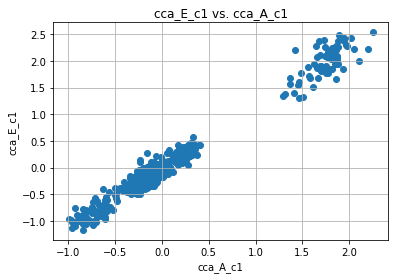

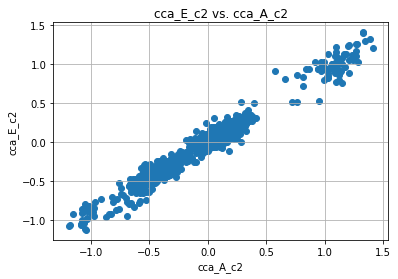

In [ ]:
plt.scatter(allData["cca_A_c1"], allData["cca_E_c1"])
plt.title('cca_E_c1 vs. cca_A_c1')
plt.ylabel('cca_E_c1')
plt.xlabel('cca_A_c1')
plt.grid()
plt.show()

plt.scatter(allData["cca_A_c2"], allData["cca_E_c2"])
plt.title('cca_E_c2 vs. cca_A_c2')
plt.ylabel('cca_E_c2')
plt.xlabel('cca_A_c2')
plt.grid()
plt.show()

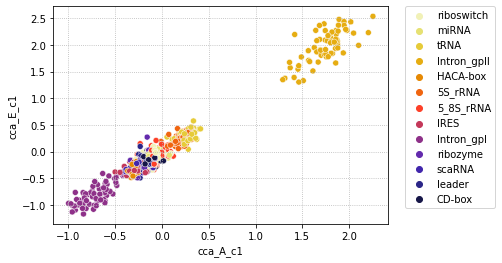

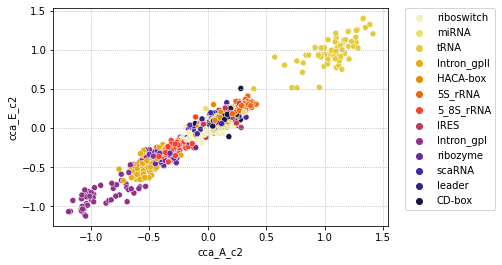

In [ ]:
import seaborn as sns
sns.scatterplot(data=allData, x="cca_A_c1", y="cca_E_c1", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.show()

sns.scatterplot(data=allData, x="cca_A_c2", y="cca_E_c2", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.show()

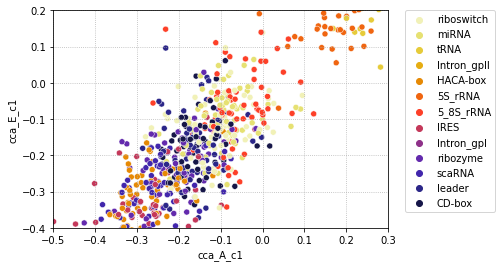

In [ ]:
sns.scatterplot(data=allData, x="cca_A_c1", y="cca_E_c1", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.ylim(-0.4, 0.2)
plt.xlim(-0.5, 0.3)
plt.show()

# g.set(ylim=(0, None))

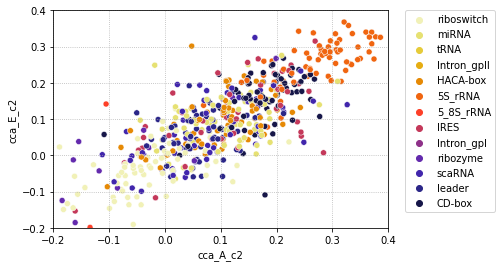

In [ ]:
sns.scatterplot(data=allData, x="cca_A_c2", y="cca_E_c2", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.ylim(-0.2, 0.4)
plt.xlim(-0.2, 0.4)
plt.show()

In [ ]:
# allData.to_csv(f"/content/drive/MyDrive/data_papers/ncRNA/cca/features_A_E_CCA.csv",index=False)

In [ ]:
# do PCA on A and PCA on E, and do the same plot you showed with PC1(A) vs PC1(E)?

In [ ]:
featuresA = allData[[x for x in allData.columns.values if "feature_A" in x]].copy()
featuresE = allData[[x for x in allData.columns.values if "feature_E" in x]].copy()

In [ ]:
from sklearn.decomposition import PCA
pca_fA = PCA(n_components=4)
pca_fA.fit(featuresA)
pca_fE = PCA(n_components=4)
pca_fE.fit(featuresE)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
loadings = pd.DataFrame(np.concatenate([pca_fA.components_.T,pca_fE.components_.T],axis=1), columns=['PC1_cnn_A', 'PC2_cnn_A','PC3_cnn_A','PC4_cnn_A','PC1_rnn_E', 'PC2_rnn_E','PC3_rnn_E','PC4_rnn_E']) 

In [ ]:
loadings

,PC1_cnn_A,PC2_cnn_A,PC3_cnn_A,PC4_cnn_A,PC1_rnn_E,PC2_rnn_E,PC3_rnn_E,PC4_rnn_E
0,-0.209545,0.061138,-0.106378,0.013128,-0.132419,0.086474,0.096126,-0.144189
1,0.239322,0.144691,-0.043277,-0.012179,0.083948,-0.174660,-0.156492,0.030508
2,-0.135672,0.098908,0.256693,0.036570,-0.144089,-0.078857,-0.075939,-0.160509
3,-0.057852,0.152485,0.162846,-0.208112,0.019496,-0.095426,-0.154490,0.043245
4,-0.142326,0.139788,0.138017,-0.151192,-0.143445,-0.066102,-0.022217,-0.214418
...,...,...,...,...,...,...,...,...
59,-0.083598,0.213317,-0.181069,-0.115713,0.094057,0.062217,-0.094169,-0.007557
60,0.193057,-0.015730,0.189262,-0.006184,-0.077211,0.076443,0.011968,0.087420
61,-0.115476,-0.178439,-0.085209,-0.086652,0.140025,-0.116904,-0.092408,0.178172
62,0.037741,0.000008,0.004609,0.179769,-0.007498,0.037098,-0.239415,-0.133547


In [ ]:
LPCA1_cnn_A = np.apply_along_axis(lambda x: np.dot(x,loadings["PC1_cnn_A"].to_numpy()),1,featuresA)   # featuresA.shape (858, 64)
LPCA2_cnn_A = np.apply_along_axis(lambda x: np.dot(x,loadings["PC2_cnn_A"].to_numpy()),1,featuresA)
LPCA3_cnn_A = np.apply_along_axis(lambda x: np.dot(x,loadings["PC3_cnn_A"].to_numpy()),1,featuresA)
LPCA4_cnn_A = np.apply_along_axis(lambda x: np.dot(x,loadings["PC4_cnn_A"].to_numpy()),1,featuresA)

LPCA1_rnn_E = np.apply_along_axis(lambda x: np.dot(x,loadings["PC1_rnn_E"].to_numpy()),1,featuresE)
LPCA2_rnn_E = np.apply_along_axis(lambda x: np.dot(x,loadings["PC2_rnn_E"].to_numpy()),1,featuresE)
LPCA3_rnn_E = np.apply_along_axis(lambda x: np.dot(x,loadings["PC3_rnn_E"].to_numpy()),1,featuresE)
LPCA4_rnn_E = np.apply_along_axis(lambda x: np.dot(x,loadings["PC4_rnn_E"].to_numpy()),1,featuresE)

allData["LPCA1_cnn_A"] = LPCA1_cnn_A
allData["LPCA2_cnn_A"] = LPCA2_cnn_A
allData["LPCA3_cnn_A"] = LPCA3_cnn_A
allData["LPCA4_cnn_A"] = LPCA4_cnn_A

allData["LPCA1_rnn_E"] = LPCA1_rnn_E
allData["LPCA2_rnn_E"] = LPCA2_rnn_E
allData["LPCA3_rnn_E"] = LPCA3_rnn_E
allData["LPCA4_rnn_E"] = LPCA4_rnn_E


In [ ]:
# allData.to_csv(f"/content/drive/MyDrive/data_papers/ncRNA/cca/features_A_E_CCA.csv",index=False)

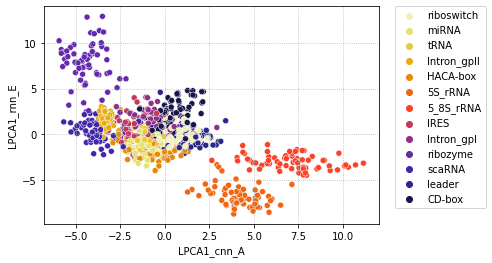

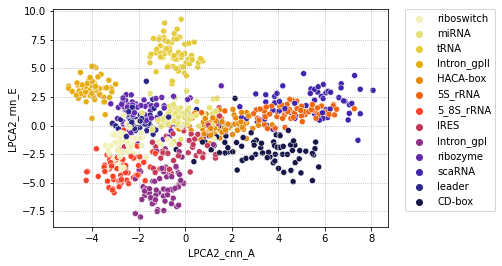

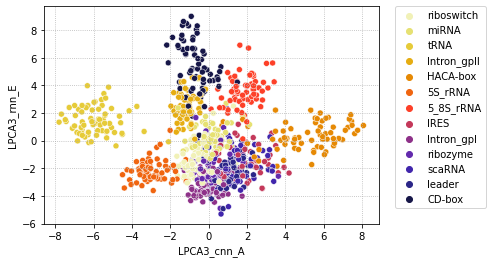

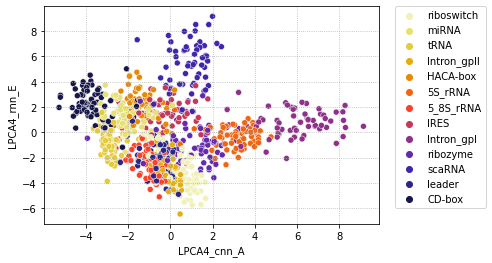

In [ ]:
import seaborn as sns
sns.scatterplot(data=allData, x="LPCA1_cnn_A", y="LPCA1_rnn_E", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.show()

sns.scatterplot(data=allData, x="LPCA2_cnn_A", y="LPCA2_rnn_E", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.show()

sns.scatterplot(data=allData, x="LPCA3_cnn_A", y="LPCA3_rnn_E", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.show()

sns.scatterplot(data=allData, x="LPCA4_cnn_A", y="LPCA4_rnn_E", hue="ClassName", legend="full", palette=sns.color_palette("CMRmap_r", 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='dotted')
plt.show()

In [ ]:
print(np.corrcoef(allData["LPCA1_cnn_A"],allData["LPCA1_rnn_E"]))
print(np.corrcoef(allData["LPCA2_cnn_A"],allData["LPCA2_rnn_E"]))
print(np.corrcoef(allData["LPCA3_cnn_A"],allData["LPCA3_rnn_E"]))
print(np.corrcoef(allData["LPCA4_cnn_A"],allData["LPCA4_rnn_E"]))

[[ 1.         -0.64502205]
 [-0.64502205  1.        ]]
[[1.         0.07220762]
 [0.07220762 1.        ]]
[[ 1.         -0.06067276]
 [-0.06067276  1.        ]]
[[ 1.         -0.06825844]
 [-0.06825844  1.        ]]


In [ ]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)  